Copyright (C) Egon Kidmose 2015-2017

This file is part of lstm-rnn-correlation.

lstm-rnn-correlation is free software: you can redistribute it and/or
modify it under the terms of the GNU Lesser General Public License as
published by the Free Software Foundation, either version 3 of the
License, or (at your option) any later version.

lstm-rnn-correlation is distributed in the hope that it will be
useful, but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU
Lesser General Public License for more details.

You should have received a copy of the GNU Lesser General Public
License along with lstm-rnn-correlation. If not, see
<http://www.gnu.org/licenses/>.


In [1]:
from __future__ import division

import pandas as pd
from pandas import DataFrame
import numpy as np
import re
import datetime
import ipaddress
import socket
import os

import lstm_rnn_tied_weights

import logging
logging.getLogger().handlers = []
logger = lstm_rnn_tied_weights.logger
runid = datetime.datetime.now().strftime("%Y%m%d-%H%M%S-") + socket.gethostname()
out_dir = 'output/alert-merging/' + runid
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
out_prefix = out_dir + '/' + runid + '-'
# info log file
infofh = logging.FileHandler(out_prefix + 'info.log')
infofh.setLevel(logging.INFO)
infofh.setFormatter(logging.Formatter(
        fmt='%(message)s',
))
logger.addHandler(infofh)
# verbose log file
vfh = logging.FileHandler(out_prefix + 'verbose.log')
vfh.setLevel(logging.DEBUG)
vfh.setFormatter(logging.Formatter(
        fmt='%(asctime)s - PID:%(process)d - %(levelname)s - %(message)s',
))
logger.addHandler(vfh)
logger.info('Output prefix: '+ out_prefix)

# matplotlib
try: # might, might not have x available
    import os
    os.environ['DISPLAY']
except KeyError:
    import matplotlib
    matplotlib.use('Agg')
try: # might, might not be notebook
    %matplotlib inline
except NameError:
    pass
import matplotlib.pyplot as plt

seed = 1468586473 # Unix time at time of writing
def rndseed():
    global seed
    seed += 1
    return seed

Output prefix: output/alert-merging/20161219-124607-js4/20161219-124607-js4-


In [2]:
IPV4 = '(?:[0-9]{1,3}(?:\.[0-9]{1,3}){3})'
IPV6 = '(?:[0-9a-f]|:){1,4}(?::(?:[0-9a-f]{0,4})*){1,7}'
IP = '(?:{}|{})'.format(IPV4, IPV6)
IP_PORT = '('+IP+')(?::([^ ]+))?'

SNORT_REGEX = re.compile('^(.*)  \[\*\*] \[([^]]*)] (.*) \[Priority: ([0-9])] {([^}]*)} ('+IP+')(?::([^ ]+))? -> ('+IP+')(?::([^ ]+))?\n')
SNORT_TS_FMT = '%m/%d/%y-%H:%M:%S.%f'
SNORT_TS_FMT_NO_YR = '%m/%d-%H:%M:%S.%f'

def strptime(string):
    ts = None
    try:
        ts = datetime.datetime.strptime(string, SNORT_TS_FMT)
    except:
        pass
    try:
        ts = datetime.datetime.strptime(string, SNORT_TS_FMT_NO_YR)
    except:
        pass
    if ts is None:
        raise Exception('Failed to parse {}: {}'.format(type(string), string))
    return ts

def strftime(ts):
    return ts.strftime(SNORT_TS_FMT)

def parse_line(line):
    tupl = re.match(SNORT_REGEX, line).groups()
    tupl = tuple([strptime(tupl[0])]) + tupl[1:]
    return tupl


def build_line(tupl):
    tupl = tuple(tupl) # pandas.core.series.Series doesn't add like tuple 
    tupl = tuple([strftime(tupl[0])]) + tupl[1:]
    return "{}  [**] [{}] {} [Priority: {}] {{{}}} {}:{} -> {}:{}\n".format(*tupl)

test_code =\
"""
for fn in data['filename']:
    for l in open(fn).readlines():
        p = parse_line(l)
        b = build_line(p)
        assert l == b or l == (b[:5]+b[8:]), "Mismatch in result"
"""

test_row = pd.Series((
        pd.tslib.Timestamp('2016-05-04 09:38:44.365433'),
        '129:12:1',
        'Consecutive TCP small segments exceeding threshold [**] [Classification: Potentially Bad Traffic]',
        '2',
        'TCP',
        '10.149.34.24',
        '445',
        '10.130.8.48',
        '60741',
))
desired_output = '05/04/16-09:38:44.365433  [**] [129:12:1] '+\
    'Consecutive TCP small segments exceeding threshold [**] [Classification: Potentially Bad Traffic] '+\
    '[Priority: 2] {TCP} 10.149.34.24:445 -> 10.130.8.48:60741\n'

assert build_line(test_row) == desired_output

In [3]:
logger.info('Loading data')
from data_cfg import data
# load files
data_tmp = DataFrame()
for index, row in data.iterrows():
    print("Opening: {}".format(row['filename']))
    with open(row['filename']) as f:
        alerts = DataFrame(
            map(parse_line, f.readlines()),
            columns=['ts', 'rid', 'msg', 'prio', 'proto', 'srcip', 'srcport', 'dstip', 'dstport']
        )
        alerts['incident'] = row['incident']   
        data_tmp = data_tmp.append(pd.merge(data, alerts))
        print("Loaded: {}".format(row['filename']))
data = data_tmp

Loading data


Opening: data/mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-46/botnet-capture-20110815-fast-flux.pcap.out
Loaded: data/mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-46/botnet-capture-20110815-fast-flux.pcap.out
Opening: data/mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-113-1/2015-03-12_capture-win6.pcap.out
Loaded: data/mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-113-1/2015-03-12_capture-win6.pcap.out
Opening: data/mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-2/2013-08-20_capture-win2.pcap.out
Loaded: data/mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-2/2013-08-20_capture-win2.pcap.out
Opening: data/mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-116-1/2012-05-25-capture-1.pcap.out
Loaded: data/mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-116-1/2012-05-25-capture-1.pcap.out
Opening: data/mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-89-1/2014-09-15_capture-wi

In [4]:
difficult_ips = [
    '94.63.149.152',
    '147.32.84.165',
]
for ip in difficult_ips:
    assert re.match('('+IP+')', ip).group()

difficult_ips_port = [
    '94.63.149.152:80',
    '147.32.84.165:1040',
]
for ip in difficult_ips_port:
    res = re.match(IP_PORT, ip).groups()
    assert res is not None
    assert len(res) == 2

difficult_lines = [
    '08/15-15:53:48.900440  [**] [120:3:1] (http_inspect) NO CONTENT-LENGTH OR TRANSFER-ENCODING IN HTTP RESPONSE [**] [Classification: Unknown Traffic] [Priority: 3] {TCP} 94.63.149.152:80 -> 147.32.84.165:1040\n',
]
for l in difficult_lines:
    res = parse_line(l)
    assert len(res) == 9

# Data preprocessing

## data overview by incident

In [5]:
def get_data_overview(data):
    df_inc_cnt = DataFrame(data.groupby(['incident']).size().rename('inc_cnt').reset_index())
    df_inc_cnt['inc_cnt_pct'] = df_inc_cnt['inc_cnt']/data.count()[0]*100

    df_inc_prio_cnt = DataFrame(
        pd.merge(data, df_inc_cnt, on='incident').groupby(['incident', 'prio', 'inc_cnt']
    ).size().rename('inc_prio_cnt').reset_index())
    df_inc_prio_cnt['inc_prio_cnt_pct'] = df_inc_prio_cnt['inc_prio_cnt']/df_inc_prio_cnt['inc_cnt']*100

    df_overview = pd.merge(df_inc_cnt, df_inc_prio_cnt).groupby(['incident', 'prio']).first().reset_index()

    tot_prio = data.groupby(['prio']).size().rename('inc_prio_cnt')
    df_tot = DataFrame(tot_prio)
    df_tot['inc_prio_cnt_pct'] = df_tot['inc_prio_cnt']/data.count()[0]*100
    df_tot['inc_cnt'] = data.count()[0]
    df_tot['inc_cnt_pct'] = 100
    df_tot['incident'] = 'total'

    df_overview = pd.concat([df_overview.reset_index(), df_tot.reset_index()])\
        .groupby(['incident', 'inc_cnt', 'inc_cnt_pct', 'prio', ])\
        .first().drop('index', 1)

    return df_overview

logger.info('Overview of unprocessed data')
df_overview = get_data_overview(data)
logger.debug(df_overview.to_latex())
logger.debug(df_overview.to_string())
df_overview

Overview of unprocessed data


inc_prio_cnt  inc_prio_cnt_pct
incident inc_cnt inc_cnt_pct prio                                
1        100     0.001802    1                1          1.000000
                             2               79         79.000000
                             3               20         20.000000
2        184     0.003315    1                3          1.630435
                             2               35         19.021739
                             3              146         79.347826
3        317     0.005711    1              313         98.738170
                             3                4          1.261830
4        328     0.005909    2              305         92.987805
                             3               23          7.012195
5        390     0.007026    2              385         98.717949
                             3                5          1.282051
6        395     0.007116    1               15          3.797468
                             2              306         77.468354
                             3               74         18.734177
7        444     0.007999    1               35          7.882883
                             2              404         90.990991
                             3                5          1.126126
benign   5548539 99.961122   1              104          0.001874
                             2          4028411         72.603094
                             3          1520024         27.395031
total    5550697 100.000000  1              471          0.008485
                             2          4029925         72.602143
                             3          1520301         27.389371

## Discard true alerts found in the false alert set
The set of false alerts also contains true alerts, i.e. wrong label.   
We strive to discard those.  
Discarding is done according to lists of bad IP addresses. If either source or destination of an alert match it is discarded.

### Comercial solution
A commercial detection solution provides a list of IPs that was found to have been infected with malicious software.

Discarding might introduce a bias - this effect needs to be investigated.  
To do this we look at distribution of priority and distribution of rule IDs after discarding.  
This is compared to the same prior to discarding. 

In [6]:
logger.info('Discard by commercial')

def srcip_or_dstip_in_row(row, ip_list):
    return row['srcip'] in ip_list or \
        row['dstip'] in ip_list

test_srcip = '94.63.149.152'
test_dstip ='147.32.84.165'
test_row = pd.Series({'srcip':test_srcip, 'dstip':test_dstip})
assert srcip_or_dstip_in_row(test_row, [test_srcip])
assert srcip_or_dstip_in_row(test_row, [test_dstip])
assert srcip_or_dstip_in_row(test_row, [test_srcip, test_srcip])
assert not srcip_or_dstip_in_row(test_row, list())


Discard by commercial


In [7]:
with open('data/own-recordings/commercial-discard-ips.csv') as f:
    ips_discard_commercial = f.readlines()
    ips_discard_commercial = map(str.strip, ips_discard_commercial)

idx_disc_com = data.apply(
    lambda row : srcip_or_dstip_in_row(row, ips_discard_commercial),
    axis=1,
)

assert data[((data['incident']!='benign') & (idx_disc_com))].size == 0, "non-benign should not be discarded"

In [8]:
# on the benign group before discarding
idx_benign = data['incident'] == 'benign'
benign_prio_size = data[idx_benign].groupby('prio').size()

In [9]:
logger.info('Priority distribution before and after discard by commercial:')
disc_com_prio_size = data[idx_benign & (idx_disc_com == False)].groupby('prio').size()
df_prio_before_after_comm = pd.concat(
    [
        benign_prio_size.rename('Count, all benign'), 
        (benign_prio_size/benign_prio_size.sum()*100).rename('Percentage, all benign'),
        disc_com_prio_size.rename('Count, after discard by commercial'),
        (disc_com_prio_size/disc_com_prio_size.sum()*100).rename('Percentage, after discard by commercial'),
    ],
    axis=1,
)

logger.debug(df_prio_before_after_comm.to_latex())
logger.debug(df_prio_before_after_comm.to_string())
df_prio_before_after_comm

Priority distribution before and after discard by commercial:


,"Count, all benign","Percentage, all benign","Count, after discard by commercial","Percentage, after discard by commercial"
prio,,,,
1,104,0.001874,104,0.001964
2,4028411,72.603094,3776531,71.300571
3,1520024,27.395031,1520000,28.697465


In [10]:
logger.info(
    "Unique rule IDs in orignal benign: %d" % 
    data[idx_benign].groupby('rid').size().size
)
logger.info(
    "Unique rule IDs in alerts discarded by comercial: %d" % 
    data[idx_benign & idx_disc_com].groupby('rid').size().size
)
logger.info(
    "Unique rule IDs after discarding: %d" % 
    data[idx_benign & (idx_disc_com == False)].groupby('rid').size().size
)

Unique rule IDs in orignal benign: 49
Unique rule IDs in alerts discarded by comercial: 5
Unique rule IDs after discarding: 49


### Manual inspection
Heuristics are applied, aiming to find the most likely true alerts, and they are manually investigated.  
A list is produced, consisting of all IPs in alerts that was matched by heuristics, that could no be confirmed to be false.

The same analysis of bias as above is performed.

In [11]:
logger.info('Discard by manual')
with open('data/own-recordings/manual-discard-ips.csv') as f:
    ips_discard_manual = f.readlines()
    ips_discard_manual = map(str.strip, ips_discard_manual)

idx_disc_man = data.apply(
    lambda row : srcip_or_dstip_in_row(row, ips_discard_manual),
    axis=1,
)
assert data[((data['incident']!='benign') & (idx_disc_man))].size == 0, "non-benign should not be discarded"

Discard by manual


In [12]:
print('Priority distribution before and after discard by manual:')
disc_man_prio_size = data[idx_benign & (idx_disc_man == False)].groupby('prio').size()
df_prio_before_after_manual = pd.concat(
    [
        benign_prio_size.rename('Count, all benign'), 
        (benign_prio_size/benign_prio_size.sum()*100).rename('Percentage, all benign'),
        disc_man_prio_size.rename('Count, after discard by manual'),
        (disc_man_prio_size/disc_man_prio_size.sum()*100).rename('Percentage, after discard by manual'),
    ],
    axis=1,
)

logger.debug(df_prio_before_after_manual.to_latex())
logger.debug(df_prio_before_after_manual.to_string())
df_prio_before_after_manual

Priority distribution before and after discard by manual:


,"Count, all benign","Percentage, all benign","Count, after discard by manual","Percentage, after discard by manual"
prio,,,,
1,104,0.001874,67,0.001386
2,4028411,72.603094,3421118,70.760250
3,1520024,27.395031,1413617,29.238364


In [13]:
logger.info(
    "Unique rule IDs in orignal benign: %d" % 
    data[idx_benign].groupby('rid').size().size
)
logger.info(
    "Unique rule IDs in alerts discarded by manual: %d" % 
    data[idx_benign & idx_disc_man].groupby('rid').size().size
)
logger.info(
    "Unique rule IDs after discarding: %d" % 
    data[idx_benign & (idx_disc_man == False)].groupby('rid').size().size
)

Unique rule IDs in orignal benign: 49
Unique rule IDs in alerts discarded by manual: 35
Unique rule IDs after discarding: 44


### Manual and commercial, effects of discarding both 

In [14]:
print('Priority distribution before and after discard:')
disc_prio_size = data[idx_benign & (idx_disc_com == False) & (idx_disc_man == False)].groupby('prio').size()
df_prio_before_after = pd.concat(
    [
        benign_prio_size.rename('Count, all benign'), 
        (benign_prio_size/benign_prio_size.sum()*100).rename('Percentage, all benign'),
        disc_prio_size.rename('Count, after discard'),
        (disc_prio_size/disc_prio_size.sum()*100).rename('Percentage, after discard'),
    ],
    axis=1,
)
logger.debug(df_prio_before_after.to_latex())
logger.debug(df_prio_before_after.to_string())
df_prio_before_after

Priority distribution before and after discard:


,"Count, all benign","Percentage, all benign","Count, after discard","Percentage, after discard"
prio,,,,
1,104,0.001874,67,0.001462
2,4028411,72.603094,3169238,69.153579
3,1520024,27.395031,1413593,30.844959


In [15]:
logger.info(
    "Unique rule IDs in orignal benign: %d" % 
    data[idx_benign].groupby('rid').size().size
)
logger.info(
    "Unique rule IDs in alerts discarded: %d" % 
    data[idx_benign & (idx_disc_man | idx_disc_com)].groupby('rid').size().size
)
logger.info(
    "Unique rule IDs after discarding: %d" % 
    data[idx_benign & ((idx_disc_man | idx_disc_com)==False)].groupby('rid').size().size
)

Unique rule IDs in orignal benign: 49
Unique rule IDs in alerts discarded: 35
Unique rule IDs after discarding: 44


In [16]:
logger.info('Analysing amount of discard by rule ID')
df_discard = pd.concat(
    [
        data[idx_benign].groupby('rid').size().rename('before'),
        data[idx_benign & (idx_disc_com == False)].groupby('rid').size().rename('com'),
        data[idx_benign & (idx_disc_man == False)].groupby('rid').size().rename('man'),
        data[idx_benign & ((idx_disc_man | idx_disc_com)==False)].groupby('rid').size().rename('both'),
    ],
    axis=1,
).fillna(0).astype(int)


Analysing amount of discard by rule ID


In [17]:
df_discard['Commercial'] = (df_discard['before']-df_discard['com'])/df_discard['before']*100
df_discard['Manual'] = (df_discard['before']-df_discard['man'])/df_discard['before']*100
df_discard['Both'] = (df_discard['before']-df_discard['both'])/df_discard['before']*100

logger.debug(df_discard.to_latex())
logger.debug(df_discard.to_string())
df_prio_before_after

,"Count, all benign","Percentage, all benign","Count, after discard","Percentage, after discard"
prio,,,,
1,104,0.001874,67,0.001462
2,4028411,72.603094,3169238,69.153579
3,1520024,27.395031,1413593,30.844959


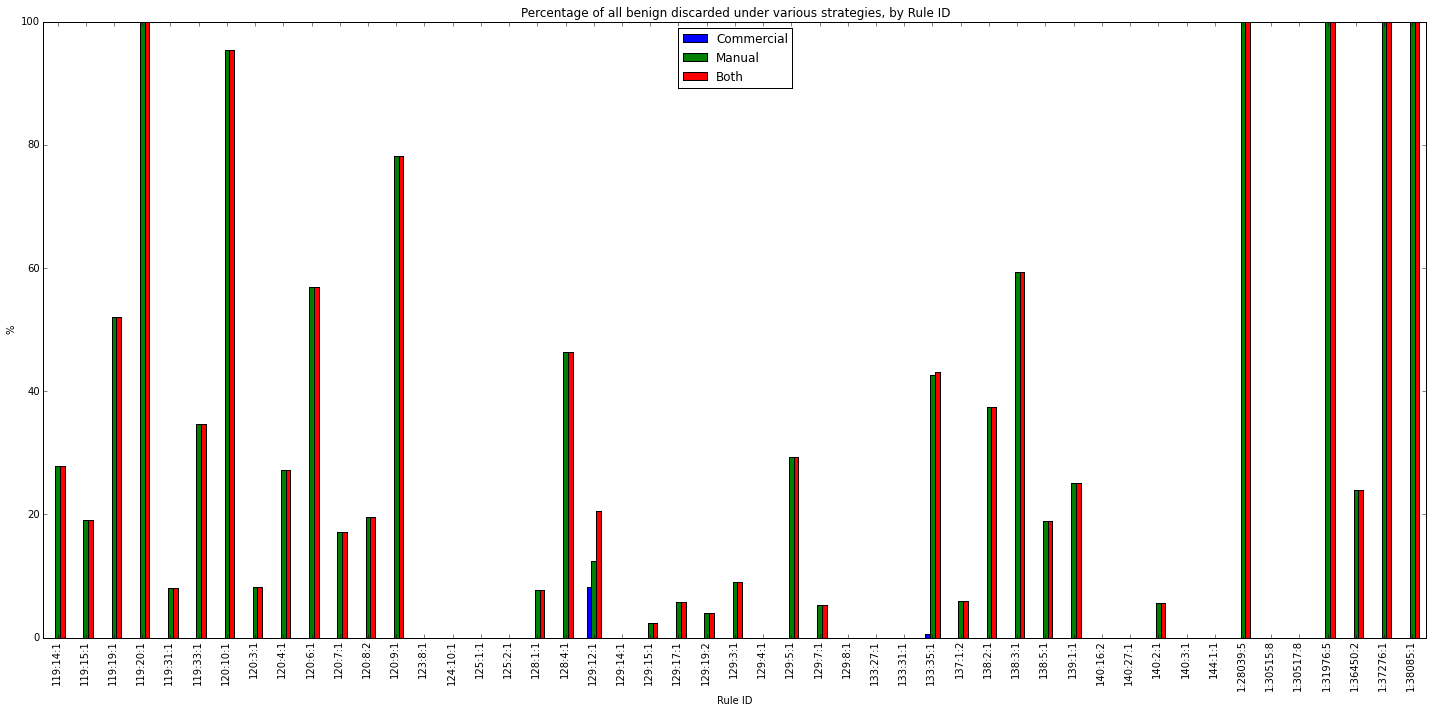

In [18]:
ax = df_discard[['Commercial', 'Manual', 'Both']].plot(kind='bar', figsize=(20,10))
ax.set_title('Percentage of all benign discarded under various strategies, by Rule ID')
ax.set_xlabel('Rule ID')
ax.set_ylabel('%')
plt.tight_layout()
plt.savefig(out_prefix+'discard_ruleid.pdf', bbox_inches='tight')

In [19]:
# Discard
data = data[((idx_disc_man | idx_disc_com)==False) | (idx_benign == False)]

## Merge in time

In [20]:
# data time overview
logger.info('Time overview, before processing')
df_ts = data[['incident', 'ts']].groupby('incident').agg(['min', 'max'])['ts']
df_ts.columns = ['start', 'stop', ]
df_ts['dur'] = df_ts['stop']-df_ts['start']

logger.debug(df_ts.to_latex())
logger.debug(df_ts.to_string())
df_ts

Time overview, before processing


,start,stop,dur
incident,,,
1,1900-08-15 15:53:38.852633,1900-08-15 16:12:55.075556,0 days 00:19:16.222923
2,1900-01-01 01:03:00.290316,1900-01-15 10:19:12.356931,14 days 09:16:12.066615
3,1900-01-01 01:07:12.199683,1900-01-04 19:54:07.258312,3 days 18:46:55.058629
4,1900-05-25 16:30:42.780734,1900-05-25 18:54:11.436165,0 days 02:23:28.655431
5,1900-01-01 01:02:27.531158,1900-01-01 02:29:21.832912,0 days 01:26:54.301754
6,1900-01-01 01:05:27.646936,1900-01-01 13:08:19.105737,0 days 12:02:51.458801
7,1900-08-16 13:28:11.935713,1900-08-17 07:42:01.247718,0 days 18:13:49.312005
benign,2016-05-04 09:38:44.365433,2016-06-09 13:29:51.193338,36 days 03:51:06.827905


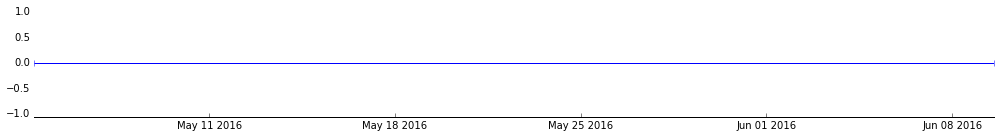

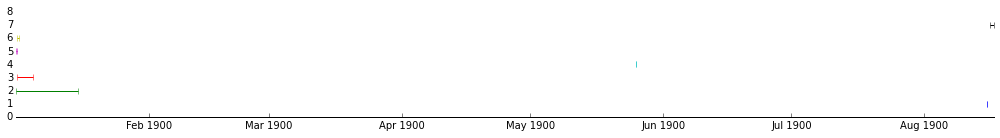

In [21]:
fig = None
ax = None
def time_span_plot(dataframe):
    "Dataframe must have 'start' and 'duration' keys"
    global fig, ax
    fig, ax = plt.subplots()
    for index, row in dataframe.iterrows():
        x = row['start'] + row['dur']/2
        y = int(index) if index is not 'benign' else 0
        xerr = row['dur']/2
        ax.errorbar(x, y, xerr=xerr)
    
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('bottom')
    
    ax.set_ylim(np.array(ax.get_ylim()) + [-1, 1])
    
    fig.set_size_inches(14, 2)

time_span_plot(df_ts[(df_ts.index == 'benign')])
plt.tight_layout()
plt.savefig(out_prefix+'timespan_benign.pdf', bbox_inches='tight')

time_span_plot(df_ts[(df_ts.index != 'benign')])
plt.tight_layout()
plt.savefig(out_prefix+'timespan_malicious.pdf', bbox_inches='tight')

In [22]:
# calculate random shift to end up within boundaries of benign
logger.info('Calculating random shifts')
new_start_min = df_ts.loc['benign']['start']
new_start_max = df_ts.loc['benign']['stop']-df_ts['dur']
window = new_start_max - new_start_min
assert (np.array(
        window+df_ts['dur']-df_ts.loc['benign']['dur'],
        dtype='object') == 0).all(), "window is wrong"

np.random.seed(rndseed())
df_ts['shift'] = new_start_min - df_ts['start'] \
    + map(lambda delta : np.random.rand()*delta, window)

logger.debug(df_ts.to_latex())
logger.debug(df_ts.to_string())
df_ts

Calculating random shifts


,start,stop,dur,shift
incident,,,,
1,1900-08-15 15:53:38.852633,1900-08-15 16:12:55.075556,0 days 00:19:16.222923,42291 days 18:41:05.279240
2,1900-01-01 01:03:00.290316,1900-01-15 10:19:12.356931,14 days 09:16:12.066615,42503 days 09:12:21.108171
3,1900-01-01 01:07:12.199683,1900-01-04 19:54:07.258312,3 days 18:46:55.058629,42497 days 01:44:17.853895
4,1900-05-25 16:30:42.780734,1900-05-25 18:54:11.436165,0 days 02:23:28.655431,42361 days 14:38:42.199517
5,1900-01-01 01:02:27.531158,1900-01-01 02:29:21.832912,0 days 01:26:54.301754,42526 days 12:23:46.071861
6,1900-01-01 01:05:27.646936,1900-01-01 13:08:19.105737,0 days 12:02:51.458801,42496 days 00:11:01.939262
7,1900-08-16 13:28:11.935713,1900-08-17 07:42:01.247718,0 days 18:13:49.312005,42272 days 10:06:10.005379
benign,2016-05-04 09:38:44.365433,2016-06-09 13:29:51.193338,36 days 03:51:06.827905,0 days 00:00:00


In [23]:
logger.info('Applying time shift')

# apply shift
shifted_data = pd.merge(data, df_ts.reset_index(), on='incident')
shifted_data['ts'] = shifted_data['ts'] + shifted_data['shift']
assert shifted_data['ts'].max() == data.groupby(['incident']).max().loc['benign']['ts']
assert shifted_data['ts'].min() == data.groupby(['incident']).min().loc['benign']['ts']
data = shifted_data
data = data.sort_values('ts')
data = data[data_tmp.columns] # only original columns

df_ts = data[['incident', 'ts']].groupby('incident').agg(['min', 'max'])['ts']
df_ts.columns = ['start', 'stop', ]
df_ts['dur'] = df_ts['stop']-df_ts['start']

logger.debug(df_ts.to_latex())
logger.debug(df_ts.to_string())
df_ts

Applying time shift


,start,stop,dur
incident,,,
1,2016-05-30 10:34:44.131873994,2016-05-30 10:54:00.354796994,0 days 00:19:16.222923
2,2016-05-15 10:15:21.398487265,2016-05-29 19:31:33.465102265,14 days 09:16:12.066615
3,2016-05-09 02:51:30.053578127,2016-05-12 21:38:25.112207127,3 days 18:46:55.058629
4,2016-05-18 07:09:24.980251846,2016-05-18 09:32:53.635682846,0 days 02:23:28.655431
5,2016-06-07 13:26:13.603019664,2016-06-07 14:53:07.904773664,0 days 01:26:54.301754
6,2016-05-08 01:16:29.586198863,2016-05-08 13:19:21.044999863,0 days 12:02:51.458801
7,2016-05-11 23:34:21.941092222,2016-05-12 17:48:11.253097222,0 days 18:13:49.312005
benign,2016-05-04 09:38:44.365433000,2016-06-09 13:29:51.193338000,36 days 03:51:06.827905


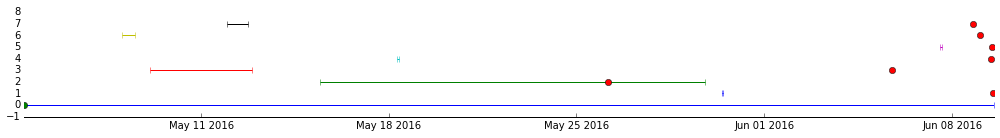

In [24]:
time_span_plot(df_ts)
ax.plot(new_start_min, 0, 'og')
ax.plot(new_start_max[:-1], range(1, len(new_start_max)), 'or')
plt.tight_layout()
plt.savefig(out_prefix+'timespan_merged.pdf', bbox_inches='tight')

## Merge in IP space

In [25]:
logger.info('Merging in IP address space')

# rewrite victim IPs to match benign
malicious_ips = data[data['victim_ip'] != 'benign']\
    [['incident', 'victim_ip']].drop_duplicates()

data_benign = data[data['incident'] == 'benign']
benign_ips = pd.Series(pd.concat([data_benign['srcip'],data_benign['dstip']]).unique(), name='benign_ips')
def is_private_ip(string):
    try:
        return ipaddress.IPv4Address(string).is_private
    except ipaddress.AddressValueError:
        logger.info("ignoring IPv6 addres: {}".format(string))
        return False
    
benign_ips = benign_ips[np.array(map(is_private_ip, benign_ips))] # only private
benign_ips = benign_ips.sample(malicious_ips.shape[0], random_state=rndseed())
df_replace = DataFrame(
    zip(malicious_ips['incident'], malicious_ips['victim_ip'], benign_ips),
    columns=['incident', 'from_ip', 'to_ip']
)

logger.debug(df_replace.to_latex())
logger.debug(df_replace.to_string())
df_replace

Merging in IP address space
ignoring IPv6 addres: fe80::a97f:ea88:dbc5:ab62:5357
ignoring IPv6 addres: fe80::3139:7b55:65e8:c045:38752
ignoring IPv6 addres: fe80::3139:7b55:65e8:c045:38809


,incident,from_ip,to_ip
0,6,10.0.2.102,10.151.60.11
1,3,10.0.2.16,10.130.76.48
2,7,147.32.84.165,10.130.133.46
3,2,10.0.2.106,10.130.142.71
4,4,192.168.0.9,10.130.26.23
5,1,147.32.84.165,10.130.25.17
6,5,10.0.2.102,10.130.8.18


In [26]:
# perform IP replacement
src_update = pd.merge(data.reset_index(), df_replace, left_on=['incident', 'srcip'], right_on=['incident', 'from_ip'])
src_update['srcip'] = src_update['to_ip']
src_update = src_update.drop(['from_ip', 'to_ip'], axis=1)
src_update = src_update.set_index('index')
data.update(src_update)

dst_update = pd.merge(data.reset_index(), df_replace, left_on=['incident', 'dstip'], right_on=['incident', 'from_ip'])
dst_update['dstip'] = dst_update['to_ip']
dst_update = dst_update.drop(['from_ip', 'to_ip'], axis=1)
dst_update = dst_update.set_index('index')
data.update(dst_update)

assert (np.array(src_update.groupby('incident').size()) > 0).all(), "No src updated, highly suspicous"
assert (np.array(dst_update.groupby('incident').size()) > 0).all(), "No dst updated, highly suspicous"
assert pd.merge(data, df_replace, left_on=['incident', 'srcip'], right_on=['incident', 'from_ip']).shape[0] == 0
assert pd.merge(data, df_replace, left_on=['incident', 'dstip'], right_on=['incident', 'from_ip']).shape[0] == 0

In [27]:
# reconstruct alerts
data['alert'] = data[['ts', 'rid', 'msg', 'prio', 'proto', 'srcip', 'srcport', 'dstip', 'dstport']].apply(build_line, axis=1)

# Stratify

In [28]:
logger.info('Stratifying data such that benign make up 50 %')

malicious = data[(data['incident']!='benign')]
benign = data[(data['incident']=='benign')]
benign = benign.sample(n=len(malicious), random_state=rndseed())
data = pd.concat([benign, malicious])

# Shuffle
np.random.seed(rndseed())
data.reindex(np.random.permutation(data.index))

logger.info('Overview of stratified data')
df_overview = get_data_overview(data)
logger.debug(df_overview.to_latex())
logger.debug(df_overview.to_string())
df_overview

Stratifying data such that benign make up 50 %
Overview of stratified data


inc_prio_cnt  inc_prio_cnt_pct
incident inc_cnt inc_cnt_pct prio                                
1        100     2.316960    1                1          1.000000
                             2               79         79.000000
                             3               20         20.000000
2        184     4.263207    1                3          1.630435
                             2               35         19.021739
                             3              146         79.347826
3        317     7.344764    1              313         98.738170
                             3                4          1.261830
4        328     7.599629    2              305         92.987805
                             3               23          7.012195
5        390     9.036145    2              385         98.717949
                             3                5          1.282051
6        395     9.151993    1               15          3.797468
                             2              306         77.468354
                             3               74         18.734177
7        444     10.287303   1               35          7.882883
                             2              404         90.990991
                             3                5          1.126126
benign   2158    50.000000   2             1489         68.999073
                             3              669         31.000927
total    4316    100.000000  1              367          8.503244
                             2             3003         69.578313
                             3              946         21.918443

# Split alerts

In [29]:
logger.info('Splitting data')

# Shuffle
np.random.seed(rndseed())
data.reindex(np.random.permutation(data.index))

data = data.reset_index().reset_index().set_index('index')
data['cut'] = data.level_0 % 10
data.drop('level_0', axis=1, inplace=True)

alert_count = pd.DataFrame(data.groupby('cut').size().rename('Alert count')).T
logger.info('Alert count by cuts: \n' + alert_count.to_string())
alert_count


Splitting data
Alert count by cuts: 
cut            0    1    2    3    4    5    6    7    8    9
Alert count  432  432  432  432  432  432  431  431  431  431


cut,0,1,2,3,4,5,6,7,8,9
Alert count,432,432,432,432,432,432,431,431,431,431


# Save alerts

In [30]:
logger.info('Saving alerts')
data.to_csv(
    'data/own-recordings/alerts-merged-cleaned-strat50-cross-val.log.1465471791',
    columns=['incident', 'alert', 'cut'],
    index=False,
)
logger.info('Saved alerts')

Saving alerts
Saved alerts


In [31]:
logger.info('Saving test alerts')
data_test = DataFrame()
for (i, c) in [(i, c) for i in data['incident'].unique() for c in data['cut'].unique()]:
    data_test = pd.concat([
        data_test,
        data[(data['incident'] == i) & (data['cut'] == c)].head(100)
    ])
data_test.to_csv(
    'data/own-recordings/alerts-merged-cleaned-strat50-cross-val.log.1465471791.test',
    columns=['incident', 'alert', 'cut'],
    index=False,
)
logger.info('Saved test alerts')

Saving test alerts
Saved test alerts


In [32]:
logger.info('Completed')

Completed
